In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()

import numpy
import tensorflow
import tensorflow.keras as keras
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalMaxPool2D, GlobalAveragePooling2D, BatchNormalization, SpatialDropout2D, LeakyReLU, Conv2D, AveragePooling2D, Dropout, Flatten, Lambda, Dense, MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(1)


Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22#43#22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14#28#14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16#32#16
        self.data_dir = 'E:\Skelnet2D\data\SHREC\\'
C = Config()

In [4]:
# model
dropout_probability = 0.1
duration = 32
n_classes = 28
n_channels = 22  # usually  n_channels = 2 * n_joints  or  n_channels = 3 * n_joints
filters = 64

In [5]:
def c2D(x,filters,kernel):
    x = Conv2D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = SpatialDropout2D(dropout_probability)(x)
    return x

def block(x,filters):
    x = c2D(x,filters,3)
    x = c2D(x,filters,3)
    return x
    
def d2D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

In [6]:
def create_model(n_classes, duration, n_channels, dropout_probability=0.2):
    model_input = Input(shape=(duration, n_channels,3))
    
    high = c2D(model_input, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    
    low = c2D(model_input, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    
    ap_residual = AveragePooling2D((2, 2), padding='same', input_shape=(32,n_channels, 1))(model_input)
    ap_residual = AveragePooling2D((2, 2), padding='same')(ap_residual)
    ap_residual = AveragePooling2D((2, 2), padding='same')(ap_residual)
    
    channel_output = concatenate([low,high,ap_residual])
    features = block(channel_output,filters*2)
    features = block(channel_output,filters*2)
    features = GlobalAveragePooling2D()(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    model_output = Dense(units=n_classes, activation='softmax')(features)
        
    model = Model(inputs=[model_input], outputs=[model_output])
    return model

In [7]:
model = create_model(n_classes=n_classes, duration=duration, n_channels=n_channels, dropout_probability=dropout_probability)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 22, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 22, 128)  3456        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 22, 128)  18816       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 32, 22, 128)  512         conv2d_3[0][0]                   
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 4, 3, 128)    147456      spatial_dropout2d_8[0][0]        
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 4, 3, 128)    512         conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 4, 3, 128)    0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
spatial_dropout2d_9 (SpatialDro (None, 4, 3, 128)    0           leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 128)          0           spatial_dropout2d_9[0][0]        
__________

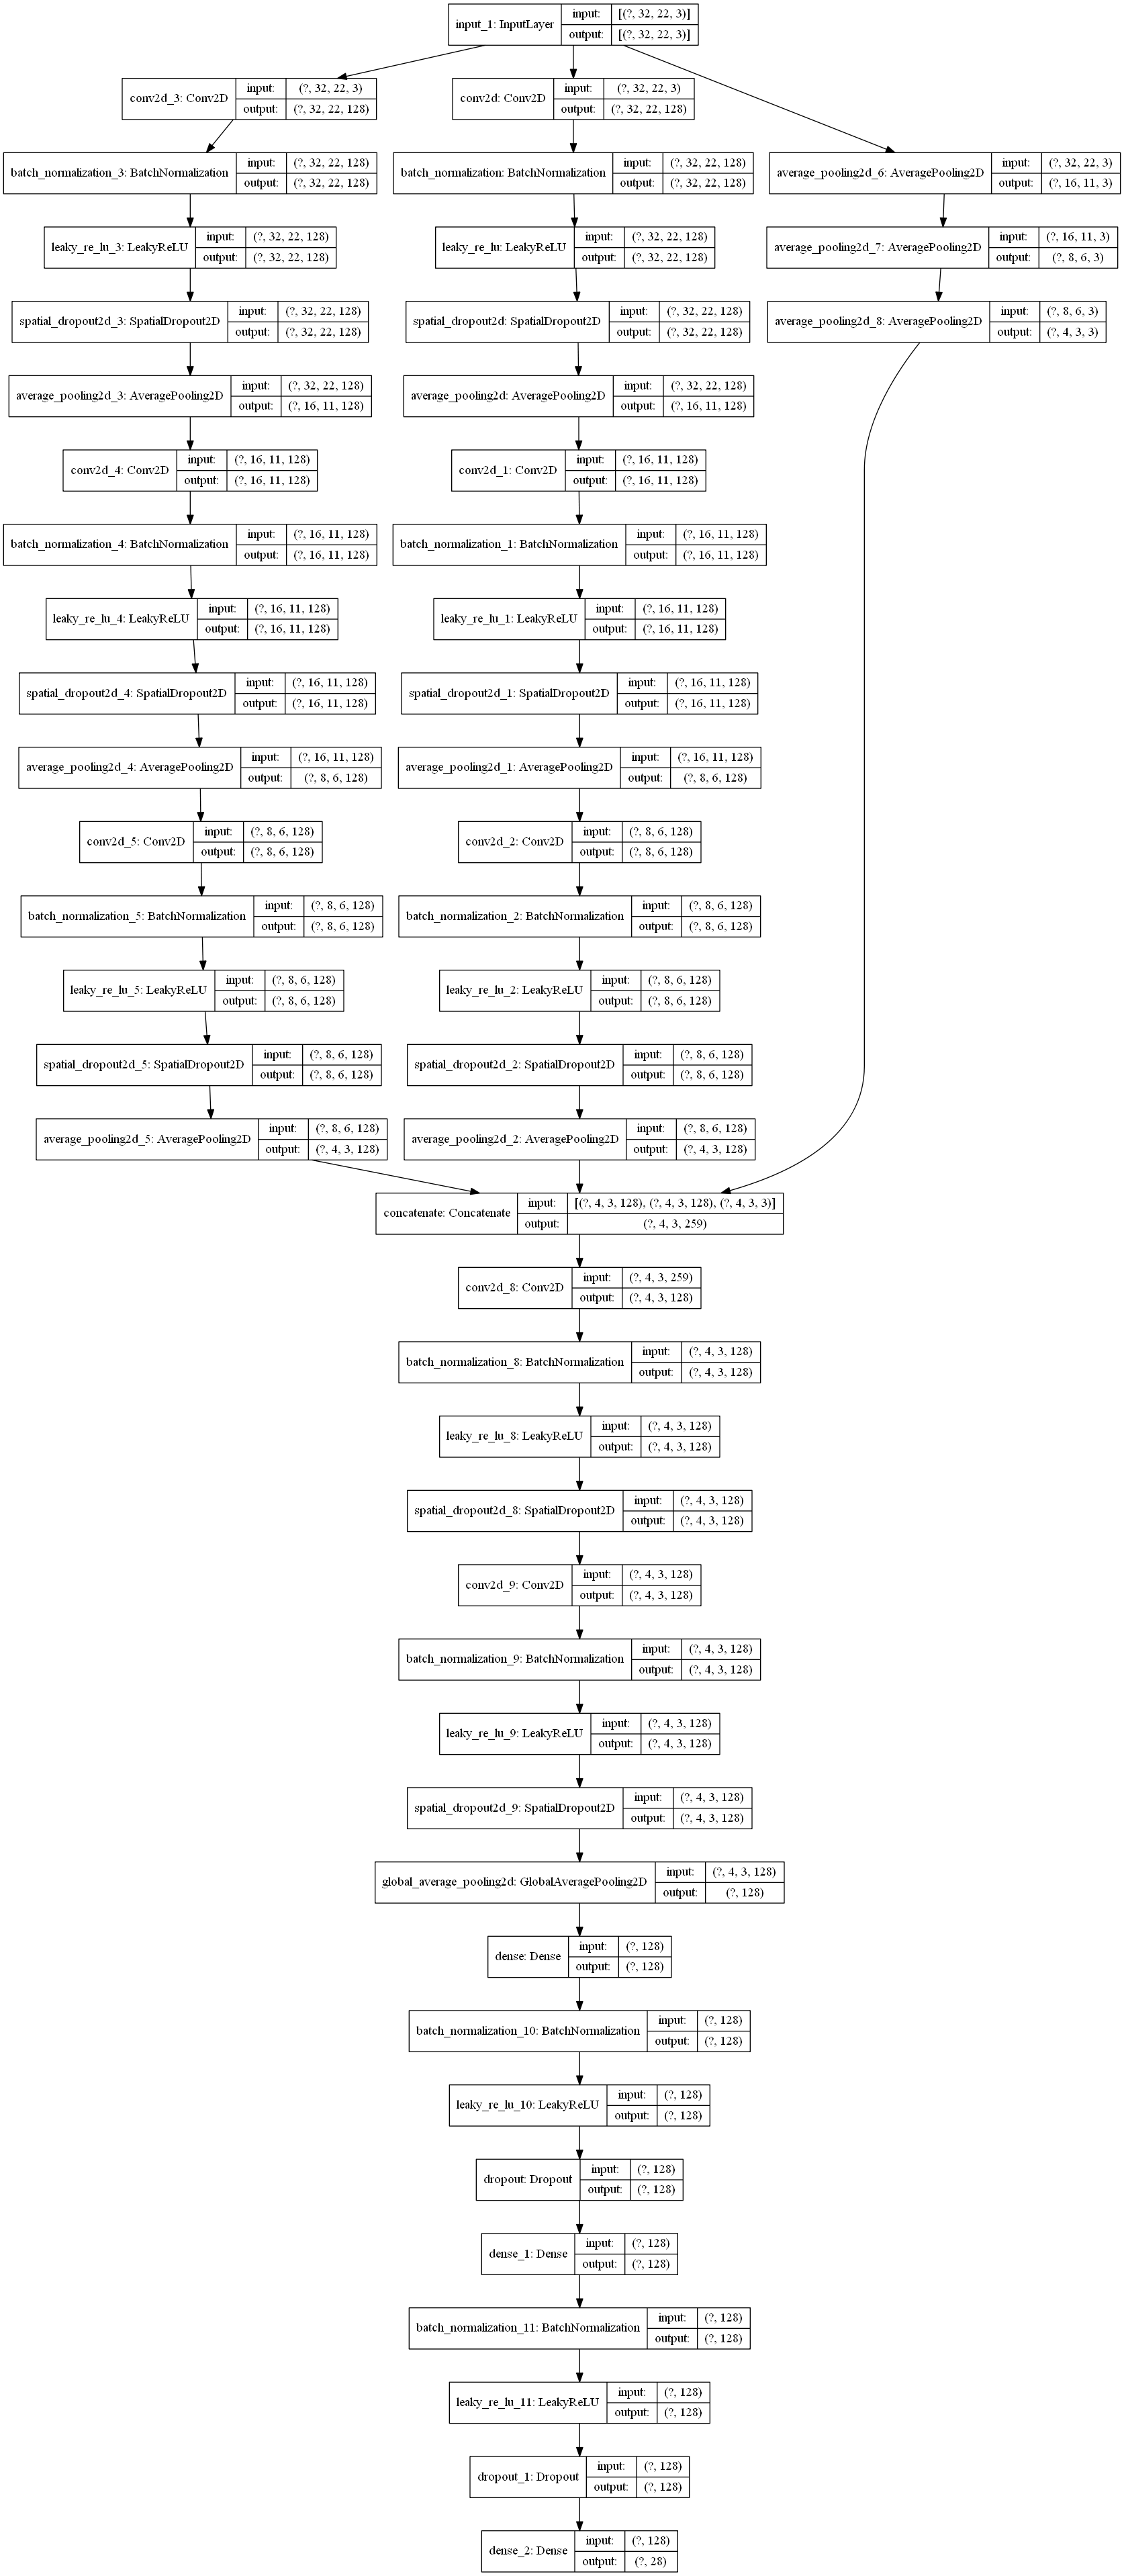

In [9]:
plot_model(model, to_file='model.png', show_shapes=True)

In [10]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

In [11]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Train['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  2%|█▌                                                                             | 40/1960 [00:00<00:09, 196.93it/s]C:\Users\Joseph\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|█████████████████████████████████████████████████████████████████████████████| 1960/1960 [00:09<00:00, 210.24it/s]


In [12]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Test['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 840/840 [00:04<00:00, 208.24it/s]


In [13]:
"""blank = X_1
blank_test = X_test_1
blank = np.zeros((1960,32,43,3))
blank_test = np.zeros((840,32,43,3))
list = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]
count = 0
for i in range(0,X_1.shape[0]):
    for j in range(0, X_1.shape[1]):
        count = 0
        for k in list:
            blank[i][j][count] = X_1[i][j][k-1]
            count = count + 1
count = 0
for i in range(0, X_test_1.shape[0]):
    for j in range(0, X_test_1.shape[1]):
        count = 0
        for k in list:
            blank_test[i][j][count] = X_test_1[i][j][k-1]
            count = count + 1
X_1 = blank
X_test_1 = blank_test"""

'blank = X_1\nblank_test = X_test_1\nblank = np.zeros((1960,32,43,3))\nblank_test = np.zeros((840,32,43,3))\nlist = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]\ncount = 0\nfor i in range(0,X_1.shape[0]):\n    for j in range(0, X_1.shape[1]):\n        count = 0\n        for k in list:\n            blank[i][j][count] = X_1[i][j][k-1]\n            count = count + 1\ncount = 0\nfor i in range(0, X_test_1.shape[0]):\n    for j in range(0, X_test_1.shape[1]):\n        count = 0\n        for k in list:\n            blank_test[i][j][count] = X_test_1[i][j][k-1]\n            count = count + 1\nX_1 = blank\nX_test_1 = blank_test'

In [14]:
# Training: Optimizer's Learning Rate
learning_rate = 0.001

# We use Adam to optimize a multi-class classification task
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
# Start the training

# ...with an existing validation set:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=1e-8)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_Skel2D.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_1, Y, validation_data=(X_test_1, Y_test), epochs=10000, batch_size=32, callbacks=[reduce_lr,es,mc])

# ...or, if there is no validation set:
# history = model.fit(x_train, y_train, validation_split=0.33, epochs=100, batch_size=32)

Train on 1960 samples, validate on 840 samples
Epoch 1/10000
1952/1960 [============================>.] - ETA: 1:45 - loss: 3.8790 - acc: 0.0000e+0 - ETA: 59s - loss: 3.6758 - acc: 0.0625    - ETA: 43s - loss: 3.4341 - acc: 0.12 - ETA: 35s - loss: 3.3664 - acc: 0.11 - ETA: 30s - loss: 3.2738 - acc: 0.11 - ETA: 27s - loss: 3.2120 - acc: 0.12 - ETA: 25s - loss: 3.1674 - acc: 0.13 - ETA: 23s - loss: 3.1398 - acc: 0.14 - ETA: 21s - loss: 3.1112 - acc: 0.14 - ETA: 20s - loss: 3.0693 - acc: 0.15 - ETA: 19s - loss: 3.0395 - acc: 0.15 - ETA: 18s - loss: 3.0352 - acc: 0.14 - ETA: 17s - loss: 2.9870 - acc: 0.15 - ETA: 16s - loss: 2.9634 - acc: 0.15 - ETA: 16s - loss: 2.9550 - acc: 0.15 - ETA: 15s - loss: 2.9178 - acc: 0.16 - ETA: 14s - loss: 2.8760 - acc: 0.18 - ETA: 14s - loss: 2.8546 - acc: 0.18 - ETA: 13s - loss: 2.8376 - acc: 0.19 - ETA: 13s - loss: 2.8114 - acc: 0.19 - ETA: 12s - loss: 2.7877 - acc: 0.20 - ETA: 12s - loss: 2.7669 - acc: 0.20 - ETA: 12s - loss: 2.7534 - acc: 0.20 - ETA: 11s 

1952/1960 [============================>.] - ETA: 14s - loss: 0.8336 - acc: 0.81 - ETA: 14s - loss: 0.8914 - acc: 0.73 - ETA: 14s - loss: 0.8664 - acc: 0.72 - ETA: 14s - loss: 0.8721 - acc: 0.69 - ETA: 13s - loss: 0.8453 - acc: 0.71 - ETA: 13s - loss: 0.8725 - acc: 0.70 - ETA: 13s - loss: 0.8917 - acc: 0.70 - ETA: 13s - loss: 0.8880 - acc: 0.70 - ETA: 12s - loss: 0.8790 - acc: 0.70 - ETA: 12s - loss: 0.8517 - acc: 0.71 - ETA: 12s - loss: 0.8309 - acc: 0.71 - ETA: 12s - loss: 0.8562 - acc: 0.70 - ETA: 11s - loss: 0.8744 - acc: 0.68 - ETA: 11s - loss: 0.8792 - acc: 0.68 - ETA: 11s - loss: 0.8693 - acc: 0.68 - ETA: 11s - loss: 0.8660 - acc: 0.69 - ETA: 10s - loss: 0.8687 - acc: 0.69 - ETA: 10s - loss: 0.8588 - acc: 0.70 - ETA: 10s - loss: 0.8609 - acc: 0.70 - ETA: 10s - loss: 0.8547 - acc: 0.70 - ETA: 9s - loss: 0.8448 - acc: 0.7098 - ETA: 9s - loss: 0.8455 - acc: 0.710 - ETA: 9s - loss: 0.8410 - acc: 0.706 - ETA: 9s - loss: 0.8499 - acc: 0.709 - ETA: 8s - loss: 0.8520 - acc: 0.708 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.3587 - acc: 0.84 - ETA: 14s - loss: 0.4551 - acc: 0.82 - ETA: 14s - loss: 0.5930 - acc: 0.80 - ETA: 14s - loss: 0.5439 - acc: 0.81 - ETA: 14s - loss: 0.5929 - acc: 0.80 - ETA: 13s - loss: 0.5901 - acc: 0.78 - ETA: 13s - loss: 0.6058 - acc: 0.78 - ETA: 13s - loss: 0.6922 - acc: 0.75 - ETA: 13s - loss: 0.6649 - acc: 0.76 - ETA: 12s - loss: 0.6401 - acc: 0.78 - ETA: 12s - loss: 0.6422 - acc: 0.77 - ETA: 12s - loss: 0.6371 - acc: 0.77 - ETA: 12s - loss: 0.6489 - acc: 0.77 - ETA: 12s - loss: 0.6672 - acc: 0.77 - ETA: 11s - loss: 0.6569 - acc: 0.77 - ETA: 11s - loss: 0.6609 - acc: 0.78 - ETA: 11s - loss: 0.6648 - acc: 0.78 - ETA: 11s - loss: 0.6455 - acc: 0.78 - ETA: 10s - loss: 0.6387 - acc: 0.79 - ETA: 10s - loss: 0.6409 - acc: 0.79 - ETA: 10s - loss: 0.6336 - acc: 0.80 - ETA: 10s - loss: 0.6331 - acc: 0.80 - ETA: 9s - loss: 0.6297 - acc: 0.8057 - ETA: 9s - loss: 0.6248 - acc: 0.806 - ETA: 9s - loss: 0.6159 - acc: 0.811 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.5131 - acc: 0.84 - ETA: 15s - loss: 0.4611 - acc: 0.82 - ETA: 14s - loss: 0.4570 - acc: 0.83 - ETA: 14s - loss: 0.4362 - acc: 0.85 - ETA: 14s - loss: 0.4030 - acc: 0.88 - ETA: 14s - loss: 0.4314 - acc: 0.86 - ETA: 13s - loss: 0.4385 - acc: 0.86 - ETA: 13s - loss: 0.4375 - acc: 0.86 - ETA: 13s - loss: 0.4754 - acc: 0.85 - ETA: 13s - loss: 0.4722 - acc: 0.85 - ETA: 13s - loss: 0.4859 - acc: 0.85 - ETA: 12s - loss: 0.4740 - acc: 0.86 - ETA: 12s - loss: 0.4649 - acc: 0.86 - ETA: 12s - loss: 0.4665 - acc: 0.86 - ETA: 12s - loss: 0.4816 - acc: 0.86 - ETA: 12s - loss: 0.4919 - acc: 0.85 - ETA: 12s - loss: 0.4863 - acc: 0.86 - ETA: 11s - loss: 0.4816 - acc: 0.86 - ETA: 11s - loss: 0.4944 - acc: 0.85 - ETA: 11s - loss: 0.4991 - acc: 0.85 - ETA: 10s - loss: 0.4974 - acc: 0.85 - ETA: 10s - loss: 0.4949 - acc: 0.85 - ETA: 10s - loss: 0.4946 - acc: 0.86 - ETA: 10s - loss: 0.4914 - acc: 0.86 - ETA: 9s - loss: 0.5041 - acc: 0.8562 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.4432 - acc: 0.87 - ETA: 15s - loss: 0.4033 - acc: 0.87 - ETA: 14s - loss: 0.3798 - acc: 0.89 - ETA: 14s - loss: 0.3929 - acc: 0.86 - ETA: 14s - loss: 0.3894 - acc: 0.86 - ETA: 14s - loss: 0.4240 - acc: 0.86 - ETA: 13s - loss: 0.4492 - acc: 0.84 - ETA: 13s - loss: 0.4554 - acc: 0.85 - ETA: 13s - loss: 0.4912 - acc: 0.84 - ETA: 13s - loss: 0.4932 - acc: 0.84 - ETA: 12s - loss: 0.5090 - acc: 0.83 - ETA: 12s - loss: 0.5030 - acc: 0.84 - ETA: 12s - loss: 0.4932 - acc: 0.84 - ETA: 12s - loss: 0.4814 - acc: 0.85 - ETA: 11s - loss: 0.4827 - acc: 0.85 - ETA: 11s - loss: 0.4743 - acc: 0.85 - ETA: 11s - loss: 0.4562 - acc: 0.86 - ETA: 11s - loss: 0.4562 - acc: 0.85 - ETA: 10s - loss: 0.4580 - acc: 0.85 - ETA: 10s - loss: 0.4624 - acc: 0.85 - ETA: 10s - loss: 0.4665 - acc: 0.85 - ETA: 10s - loss: 0.4575 - acc: 0.85 - ETA: 9s - loss: 0.4504 - acc: 0.8628 - ETA: 9s - loss: 0.4466 - acc: 0.863 - ETA: 9s - loss: 0.4439 - acc: 0.865 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.4191 - acc: 0.87 - ETA: 16s - loss: 0.3343 - acc: 0.89 - ETA: 15s - loss: 0.2731 - acc: 0.91 - ETA: 15s - loss: 0.3300 - acc: 0.89 - ETA: 14s - loss: 0.3626 - acc: 0.88 - ETA: 14s - loss: 0.3490 - acc: 0.89 - ETA: 14s - loss: 0.3801 - acc: 0.88 - ETA: 13s - loss: 0.3805 - acc: 0.87 - ETA: 13s - loss: 0.3896 - acc: 0.88 - ETA: 13s - loss: 0.4162 - acc: 0.88 - ETA: 13s - loss: 0.4095 - acc: 0.88 - ETA: 12s - loss: 0.4084 - acc: 0.87 - ETA: 12s - loss: 0.4432 - acc: 0.86 - ETA: 12s - loss: 0.4398 - acc: 0.86 - ETA: 12s - loss: 0.4344 - acc: 0.86 - ETA: 11s - loss: 0.4452 - acc: 0.86 - ETA: 11s - loss: 0.4421 - acc: 0.86 - ETA: 11s - loss: 0.4377 - acc: 0.86 - ETA: 11s - loss: 0.4276 - acc: 0.86 - ETA: 11s - loss: 0.4245 - acc: 0.86 - ETA: 10s - loss: 0.4144 - acc: 0.87 - ETA: 10s - loss: 0.4161 - acc: 0.87 - ETA: 10s - loss: 0.4198 - acc: 0.87 - ETA: 10s - loss: 0.4119 - acc: 0.87 - ETA: 9s - loss: 0.4131 - acc: 0.8700 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.1544 - acc: 0.96 - ETA: 15s - loss: 0.2252 - acc: 0.95 - ETA: 15s - loss: 0.3054 - acc: 0.93 - ETA: 14s - loss: 0.2681 - acc: 0.94 - ETA: 14s - loss: 0.2700 - acc: 0.93 - ETA: 14s - loss: 0.3008 - acc: 0.92 - ETA: 14s - loss: 0.3048 - acc: 0.92 - ETA: 13s - loss: 0.2853 - acc: 0.93 - ETA: 13s - loss: 0.2741 - acc: 0.93 - ETA: 13s - loss: 0.2851 - acc: 0.93 - ETA: 13s - loss: 0.2972 - acc: 0.92 - ETA: 12s - loss: 0.2884 - acc: 0.92 - ETA: 12s - loss: 0.2869 - acc: 0.91 - ETA: 12s - loss: 0.3011 - acc: 0.91 - ETA: 12s - loss: 0.3094 - acc: 0.91 - ETA: 11s - loss: 0.3103 - acc: 0.91 - ETA: 11s - loss: 0.3022 - acc: 0.91 - ETA: 11s - loss: 0.3016 - acc: 0.91 - ETA: 11s - loss: 0.3016 - acc: 0.91 - ETA: 10s - loss: 0.3041 - acc: 0.91 - ETA: 10s - loss: 0.3045 - acc: 0.91 - ETA: 10s - loss: 0.3036 - acc: 0.90 - ETA: 10s - loss: 0.3095 - acc: 0.90 - ETA: 9s - loss: 0.3045 - acc: 0.9089 - ETA: 9s - loss: 0.3026 - acc: 0.910 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0861 - acc: 0.96 - ETA: 15s - loss: 0.2259 - acc: 0.92 - ETA: 14s - loss: 0.2882 - acc: 0.91 - ETA: 14s - loss: 0.2687 - acc: 0.91 - ETA: 14s - loss: 0.2779 - acc: 0.90 - ETA: 14s - loss: 0.2631 - acc: 0.91 - ETA: 14s - loss: 0.2928 - acc: 0.91 - ETA: 13s - loss: 0.3001 - acc: 0.90 - ETA: 13s - loss: 0.3059 - acc: 0.89 - ETA: 13s - loss: 0.2924 - acc: 0.90 - ETA: 12s - loss: 0.2916 - acc: 0.90 - ETA: 12s - loss: 0.2968 - acc: 0.90 - ETA: 12s - loss: 0.2875 - acc: 0.90 - ETA: 12s - loss: 0.2859 - acc: 0.90 - ETA: 12s - loss: 0.2799 - acc: 0.90 - ETA: 11s - loss: 0.2905 - acc: 0.90 - ETA: 11s - loss: 0.2802 - acc: 0.90 - ETA: 11s - loss: 0.2868 - acc: 0.90 - ETA: 11s - loss: 0.2864 - acc: 0.90 - ETA: 10s - loss: 0.2793 - acc: 0.90 - ETA: 10s - loss: 0.2891 - acc: 0.90 - ETA: 10s - loss: 0.2867 - acc: 0.90 - ETA: 10s - loss: 0.2841 - acc: 0.90 - ETA: 9s - loss: 0.2820 - acc: 0.9036 - ETA: 9s - loss: 0.2777 - acc: 0.907 - ETA:

1952/1960 [============================>.] - ETA: 17s - loss: 0.2443 - acc: 0.90 - ETA: 16s - loss: 0.1603 - acc: 0.95 - ETA: 16s - loss: 0.1654 - acc: 0.95 - ETA: 16s - loss: 0.1874 - acc: 0.95 - ETA: 15s - loss: 0.1946 - acc: 0.93 - ETA: 15s - loss: 0.1845 - acc: 0.94 - ETA: 15s - loss: 0.1731 - acc: 0.95 - ETA: 14s - loss: 0.1814 - acc: 0.94 - ETA: 14s - loss: 0.1978 - acc: 0.93 - ETA: 14s - loss: 0.1965 - acc: 0.93 - ETA: 13s - loss: 0.1919 - acc: 0.93 - ETA: 13s - loss: 0.1888 - acc: 0.93 - ETA: 13s - loss: 0.1855 - acc: 0.93 - ETA: 12s - loss: 0.1896 - acc: 0.93 - ETA: 12s - loss: 0.1948 - acc: 0.93 - ETA: 12s - loss: 0.1894 - acc: 0.93 - ETA: 11s - loss: 0.1847 - acc: 0.93 - ETA: 11s - loss: 0.1998 - acc: 0.93 - ETA: 11s - loss: 0.2076 - acc: 0.93 - ETA: 11s - loss: 0.2055 - acc: 0.93 - ETA: 10s - loss: 0.2010 - acc: 0.93 - ETA: 10s - loss: 0.1992 - acc: 0.93 - ETA: 10s - loss: 0.1978 - acc: 0.93 - ETA: 10s - loss: 0.1946 - acc: 0.93 - ETA: 9s - loss: 0.2072 - acc: 0.9337 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.4010 - acc: 0.84 - ETA: 15s - loss: 0.2725 - acc: 0.89 - ETA: 15s - loss: 0.2229 - acc: 0.90 - ETA: 14s - loss: 0.2412 - acc: 0.90 - ETA: 14s - loss: 0.2063 - acc: 0.92 - ETA: 14s - loss: 0.2002 - acc: 0.92 - ETA: 14s - loss: 0.2237 - acc: 0.91 - ETA: 13s - loss: 0.2077 - acc: 0.92 - ETA: 13s - loss: 0.2035 - acc: 0.92 - ETA: 13s - loss: 0.2315 - acc: 0.92 - ETA: 12s - loss: 0.2521 - acc: 0.92 - ETA: 12s - loss: 0.2402 - acc: 0.92 - ETA: 12s - loss: 0.2493 - acc: 0.91 - ETA: 12s - loss: 0.2478 - acc: 0.91 - ETA: 11s - loss: 0.2399 - acc: 0.91 - ETA: 11s - loss: 0.2305 - acc: 0.92 - ETA: 11s - loss: 0.2276 - acc: 0.92 - ETA: 11s - loss: 0.2205 - acc: 0.92 - ETA: 10s - loss: 0.2228 - acc: 0.92 - ETA: 10s - loss: 0.2221 - acc: 0.92 - ETA: 10s - loss: 0.2289 - acc: 0.92 - ETA: 10s - loss: 0.2307 - acc: 0.92 - ETA: 9s - loss: 0.2280 - acc: 0.9253 - ETA: 9s - loss: 0.2270 - acc: 0.925 - ETA: 9s - loss: 0.2254 - acc: 0.925 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0817 - acc: 0.96 - ETA: 15s - loss: 0.0793 - acc: 0.98 - ETA: 15s - loss: 0.0719 - acc: 0.98 - ETA: 14s - loss: 0.1438 - acc: 0.96 - ETA: 14s - loss: 0.1508 - acc: 0.96 - ETA: 14s - loss: 0.1549 - acc: 0.96 - ETA: 14s - loss: 0.1569 - acc: 0.96 - ETA: 13s - loss: 0.1743 - acc: 0.95 - ETA: 13s - loss: 0.1850 - acc: 0.95 - ETA: 13s - loss: 0.1706 - acc: 0.95 - ETA: 13s - loss: 0.1609 - acc: 0.96 - ETA: 12s - loss: 0.1817 - acc: 0.95 - ETA: 12s - loss: 0.1836 - acc: 0.94 - ETA: 12s - loss: 0.2025 - acc: 0.94 - ETA: 11s - loss: 0.2172 - acc: 0.93 - ETA: 11s - loss: 0.2321 - acc: 0.93 - ETA: 11s - loss: 0.2271 - acc: 0.93 - ETA: 11s - loss: 0.2240 - acc: 0.93 - ETA: 10s - loss: 0.2200 - acc: 0.93 - ETA: 10s - loss: 0.2197 - acc: 0.93 - ETA: 10s - loss: 0.2137 - acc: 0.93 - ETA: 10s - loss: 0.2155 - acc: 0.93 - ETA: 9s - loss: 0.2200 - acc: 0.9375 - ETA: 9s - loss: 0.2148 - acc: 0.938 - ETA: 9s - loss: 0.2169 - acc: 0.936 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.1010 - acc: 0.93 - ETA: 16s - loss: 0.0817 - acc: 0.96 - ETA: 16s - loss: 0.1120 - acc: 0.94 - ETA: 15s - loss: 0.1060 - acc: 0.95 - ETA: 15s - loss: 0.1122 - acc: 0.95 - ETA: 15s - loss: 0.1408 - acc: 0.94 - ETA: 14s - loss: 0.1407 - acc: 0.95 - ETA: 14s - loss: 0.1403 - acc: 0.95 - ETA: 14s - loss: 0.1420 - acc: 0.95 - ETA: 13s - loss: 0.1382 - acc: 0.95 - ETA: 13s - loss: 0.1547 - acc: 0.95 - ETA: 13s - loss: 0.1641 - acc: 0.95 - ETA: 13s - loss: 0.1778 - acc: 0.94 - ETA: 12s - loss: 0.1758 - acc: 0.94 - ETA: 12s - loss: 0.1798 - acc: 0.94 - ETA: 12s - loss: 0.1734 - acc: 0.94 - ETA: 11s - loss: 0.1689 - acc: 0.94 - ETA: 11s - loss: 0.1642 - acc: 0.95 - ETA: 11s - loss: 0.1593 - acc: 0.95 - ETA: 11s - loss: 0.1635 - acc: 0.95 - ETA: 10s - loss: 0.1592 - acc: 0.95 - ETA: 10s - loss: 0.1599 - acc: 0.95 - ETA: 10s - loss: 0.1569 - acc: 0.95 - ETA: 10s - loss: 0.1574 - acc: 0.95 - ETA: 9s - loss: 0.1574 - acc: 0.9538 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.2784 - acc: 0.90 - ETA: 15s - loss: 0.2095 - acc: 0.93 - ETA: 15s - loss: 0.1802 - acc: 0.94 - ETA: 15s - loss: 0.1729 - acc: 0.95 - ETA: 14s - loss: 0.1724 - acc: 0.95 - ETA: 14s - loss: 0.1898 - acc: 0.93 - ETA: 14s - loss: 0.2318 - acc: 0.93 - ETA: 14s - loss: 0.2848 - acc: 0.91 - ETA: 13s - loss: 0.2723 - acc: 0.92 - ETA: 13s - loss: 0.2613 - acc: 0.92 - ETA: 13s - loss: 0.2449 - acc: 0.92 - ETA: 13s - loss: 0.2390 - acc: 0.92 - ETA: 12s - loss: 0.2408 - acc: 0.92 - ETA: 12s - loss: 0.2337 - acc: 0.92 - ETA: 12s - loss: 0.2376 - acc: 0.92 - ETA: 12s - loss: 0.2336 - acc: 0.92 - ETA: 11s - loss: 0.2240 - acc: 0.92 - ETA: 11s - loss: 0.2149 - acc: 0.93 - ETA: 11s - loss: 0.2110 - acc: 0.93 - ETA: 10s - loss: 0.2247 - acc: 0.92 - ETA: 10s - loss: 0.2238 - acc: 0.92 - ETA: 10s - loss: 0.2202 - acc: 0.92 - ETA: 10s - loss: 0.2135 - acc: 0.93 - ETA: 9s - loss: 0.2156 - acc: 0.9297 - ETA: 9s - loss: 0.2115 - acc: 0.930 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0442 - acc: 1.00 - ETA: 15s - loss: 0.0751 - acc: 1.00 - ETA: 15s - loss: 0.0726 - acc: 0.98 - ETA: 14s - loss: 0.0703 - acc: 0.98 - ETA: 14s - loss: 0.0779 - acc: 0.98 - ETA: 14s - loss: 0.1058 - acc: 0.96 - ETA: 13s - loss: 0.1222 - acc: 0.96 - ETA: 13s - loss: 0.1210 - acc: 0.96 - ETA: 13s - loss: 0.1684 - acc: 0.95 - ETA: 13s - loss: 0.1589 - acc: 0.95 - ETA: 13s - loss: 0.1499 - acc: 0.95 - ETA: 12s - loss: 0.1443 - acc: 0.95 - ETA: 12s - loss: 0.1520 - acc: 0.95 - ETA: 12s - loss: 0.1534 - acc: 0.95 - ETA: 12s - loss: 0.1559 - acc: 0.95 - ETA: 11s - loss: 0.1506 - acc: 0.95 - ETA: 11s - loss: 0.1541 - acc: 0.95 - ETA: 11s - loss: 0.1577 - acc: 0.95 - ETA: 11s - loss: 0.1514 - acc: 0.95 - ETA: 10s - loss: 0.1536 - acc: 0.95 - ETA: 10s - loss: 0.1570 - acc: 0.95 - ETA: 10s - loss: 0.1548 - acc: 0.95 - ETA: 10s - loss: 0.1531 - acc: 0.95 - ETA: 9s - loss: 0.1487 - acc: 0.9570 - ETA: 9s - loss: 0.1542 - acc: 0.956 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.3041 - acc: 0.87 - ETA: 15s - loss: 0.1802 - acc: 0.93 - ETA: 14s - loss: 0.2548 - acc: 0.92 - ETA: 14s - loss: 0.2053 - acc: 0.94 - ETA: 14s - loss: 0.2401 - acc: 0.93 - ETA: 14s - loss: 0.2648 - acc: 0.93 - ETA: 13s - loss: 0.2657 - acc: 0.93 - ETA: 13s - loss: 0.2716 - acc: 0.92 - ETA: 13s - loss: 0.3062 - acc: 0.91 - ETA: 13s - loss: 0.2824 - acc: 0.91 - ETA: 12s - loss: 0.2718 - acc: 0.91 - ETA: 12s - loss: 0.2662 - acc: 0.91 - ETA: 12s - loss: 0.2515 - acc: 0.92 - ETA: 12s - loss: 0.2408 - acc: 0.92 - ETA: 11s - loss: 0.2481 - acc: 0.92 - ETA: 11s - loss: 0.2513 - acc: 0.92 - ETA: 11s - loss: 0.2545 - acc: 0.92 - ETA: 11s - loss: 0.2459 - acc: 0.92 - ETA: 10s - loss: 0.2393 - acc: 0.92 - ETA: 10s - loss: 0.2301 - acc: 0.92 - ETA: 10s - loss: 0.2293 - acc: 0.92 - ETA: 10s - loss: 0.2239 - acc: 0.93 - ETA: 9s - loss: 0.2156 - acc: 0.9348 - ETA: 9s - loss: 0.2112 - acc: 0.936 - ETA: 9s - loss: 0.2080 - acc: 0.937 - ETA:

1952/1960 [============================>.] - ETA: 17s - loss: 0.1109 - acc: 0.93 - ETA: 16s - loss: 0.1456 - acc: 0.93 - ETA: 15s - loss: 0.1125 - acc: 0.95 - ETA: 15s - loss: 0.1023 - acc: 0.96 - ETA: 15s - loss: 0.1181 - acc: 0.96 - ETA: 14s - loss: 0.1087 - acc: 0.96 - ETA: 14s - loss: 0.0997 - acc: 0.96 - ETA: 14s - loss: 0.1128 - acc: 0.96 - ETA: 14s - loss: 0.1121 - acc: 0.96 - ETA: 13s - loss: 0.1130 - acc: 0.96 - ETA: 13s - loss: 0.1084 - acc: 0.96 - ETA: 13s - loss: 0.1110 - acc: 0.96 - ETA: 12s - loss: 0.1123 - acc: 0.95 - ETA: 12s - loss: 0.1197 - acc: 0.95 - ETA: 12s - loss: 0.1142 - acc: 0.96 - ETA: 12s - loss: 0.1113 - acc: 0.96 - ETA: 11s - loss: 0.1099 - acc: 0.96 - ETA: 11s - loss: 0.1083 - acc: 0.96 - ETA: 11s - loss: 0.1100 - acc: 0.96 - ETA: 10s - loss: 0.1158 - acc: 0.96 - ETA: 10s - loss: 0.1126 - acc: 0.96 - ETA: 10s - loss: 0.1118 - acc: 0.96 - ETA: 10s - loss: 0.1104 - acc: 0.96 - ETA: 9s - loss: 0.1111 - acc: 0.9622 - ETA: 9s - loss: 0.1091 - acc: 0.962 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0882 - acc: 0.93 - ETA: 15s - loss: 0.0756 - acc: 0.96 - ETA: 15s - loss: 0.1210 - acc: 0.95 - ETA: 14s - loss: 0.1284 - acc: 0.94 - ETA: 14s - loss: 0.1179 - acc: 0.95 - ETA: 14s - loss: 0.1254 - acc: 0.95 - ETA: 14s - loss: 0.1118 - acc: 0.95 - ETA: 13s - loss: 0.1025 - acc: 0.96 - ETA: 13s - loss: 0.0998 - acc: 0.96 - ETA: 13s - loss: 0.0931 - acc: 0.96 - ETA: 13s - loss: 0.0913 - acc: 0.97 - ETA: 12s - loss: 0.0880 - acc: 0.97 - ETA: 12s - loss: 0.0939 - acc: 0.97 - ETA: 12s - loss: 0.0922 - acc: 0.97 - ETA: 12s - loss: 0.0922 - acc: 0.97 - ETA: 11s - loss: 0.0896 - acc: 0.97 - ETA: 11s - loss: 0.0877 - acc: 0.97 - ETA: 11s - loss: 0.0879 - acc: 0.97 - ETA: 10s - loss: 0.0908 - acc: 0.97 - ETA: 10s - loss: 0.0890 - acc: 0.97 - ETA: 10s - loss: 0.0885 - acc: 0.97 - ETA: 10s - loss: 0.0892 - acc: 0.97 - ETA: 9s - loss: 0.0934 - acc: 0.9701 - ETA: 9s - loss: 0.0937 - acc: 0.970 - ETA: 9s - loss: 0.0955 - acc: 0.968 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0182 - acc: 1.00 - ETA: 15s - loss: 0.0200 - acc: 1.00 - ETA: 15s - loss: 0.0254 - acc: 1.00 - ETA: 14s - loss: 0.0231 - acc: 1.00 - ETA: 14s - loss: 0.0339 - acc: 0.98 - ETA: 14s - loss: 0.0353 - acc: 0.98 - ETA: 14s - loss: 0.0834 - acc: 0.96 - ETA: 13s - loss: 0.0783 - acc: 0.97 - ETA: 13s - loss: 0.0767 - acc: 0.96 - ETA: 13s - loss: 0.0756 - acc: 0.97 - ETA: 13s - loss: 0.0703 - acc: 0.97 - ETA: 12s - loss: 0.0821 - acc: 0.97 - ETA: 12s - loss: 0.0780 - acc: 0.97 - ETA: 12s - loss: 0.0788 - acc: 0.97 - ETA: 12s - loss: 0.0751 - acc: 0.97 - ETA: 11s - loss: 0.0710 - acc: 0.97 - ETA: 11s - loss: 0.0740 - acc: 0.97 - ETA: 11s - loss: 0.0721 - acc: 0.97 - ETA: 11s - loss: 0.0716 - acc: 0.97 - ETA: 10s - loss: 0.0688 - acc: 0.97 - ETA: 10s - loss: 0.0721 - acc: 0.97 - ETA: 10s - loss: 0.0700 - acc: 0.97 - ETA: 10s - loss: 0.0709 - acc: 0.97 - ETA: 9s - loss: 0.0687 - acc: 0.9779 - ETA: 9s - loss: 0.0724 - acc: 0.975 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0104 - acc: 1.00 - ETA: 15s - loss: 0.0154 - acc: 1.00 - ETA: 14s - loss: 0.0123 - acc: 1.00 - ETA: 14s - loss: 0.0449 - acc: 0.97 - ETA: 14s - loss: 0.0503 - acc: 0.97 - ETA: 14s - loss: 0.0480 - acc: 0.97 - ETA: 13s - loss: 0.0436 - acc: 0.98 - ETA: 13s - loss: 0.0401 - acc: 0.98 - ETA: 13s - loss: 0.0474 - acc: 0.97 - ETA: 13s - loss: 0.0444 - acc: 0.98 - ETA: 12s - loss: 0.0422 - acc: 0.98 - ETA: 12s - loss: 0.0455 - acc: 0.98 - ETA: 12s - loss: 0.0425 - acc: 0.98 - ETA: 12s - loss: 0.0509 - acc: 0.97 - ETA: 11s - loss: 0.0537 - acc: 0.97 - ETA: 11s - loss: 0.0533 - acc: 0.97 - ETA: 11s - loss: 0.0514 - acc: 0.97 - ETA: 11s - loss: 0.0494 - acc: 0.97 - ETA: 10s - loss: 0.0501 - acc: 0.97 - ETA: 10s - loss: 0.0491 - acc: 0.97 - ETA: 10s - loss: 0.0480 - acc: 0.98 - ETA: 10s - loss: 0.0466 - acc: 0.98 - ETA: 9s - loss: 0.0459 - acc: 0.9823 - ETA: 9s - loss: 0.0454 - acc: 0.983 - ETA: 9s - loss: 0.0462 - acc: 0.983 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0227 - acc: 1.00 - ETA: 15s - loss: 0.0280 - acc: 1.00 - ETA: 15s - loss: 0.0421 - acc: 0.98 - ETA: 14s - loss: 0.0377 - acc: 0.99 - ETA: 14s - loss: 0.0349 - acc: 0.99 - ETA: 14s - loss: 0.0317 - acc: 0.99 - ETA: 13s - loss: 0.0305 - acc: 0.99 - ETA: 13s - loss: 0.0283 - acc: 0.99 - ETA: 13s - loss: 0.0300 - acc: 0.99 - ETA: 13s - loss: 0.0369 - acc: 0.99 - ETA: 12s - loss: 0.0400 - acc: 0.99 - ETA: 12s - loss: 0.0446 - acc: 0.98 - ETA: 12s - loss: 0.0473 - acc: 0.98 - ETA: 12s - loss: 0.0461 - acc: 0.98 - ETA: 11s - loss: 0.0488 - acc: 0.98 - ETA: 11s - loss: 0.0489 - acc: 0.98 - ETA: 11s - loss: 0.0498 - acc: 0.98 - ETA: 11s - loss: 0.0527 - acc: 0.98 - ETA: 10s - loss: 0.0514 - acc: 0.98 - ETA: 10s - loss: 0.0558 - acc: 0.98 - ETA: 10s - loss: 0.0610 - acc: 0.98 - ETA: 10s - loss: 0.0630 - acc: 0.98 - ETA: 9s - loss: 0.0675 - acc: 0.9823 - ETA: 9s - loss: 0.0673 - acc: 0.981 - ETA: 9s - loss: 0.0656 - acc: 0.982 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0589 - acc: 0.96 - ETA: 16s - loss: 0.0387 - acc: 0.98 - ETA: 15s - loss: 0.0661 - acc: 0.97 - ETA: 15s - loss: 0.0573 - acc: 0.98 - ETA: 15s - loss: 0.0500 - acc: 0.98 - ETA: 14s - loss: 0.0494 - acc: 0.98 - ETA: 14s - loss: 0.0460 - acc: 0.98 - ETA: 14s - loss: 0.0429 - acc: 0.98 - ETA: 13s - loss: 0.0415 - acc: 0.98 - ETA: 13s - loss: 0.0393 - acc: 0.99 - ETA: 13s - loss: 0.0421 - acc: 0.98 - ETA: 13s - loss: 0.0414 - acc: 0.98 - ETA: 12s - loss: 0.0421 - acc: 0.98 - ETA: 12s - loss: 0.0401 - acc: 0.98 - ETA: 12s - loss: 0.0390 - acc: 0.98 - ETA: 12s - loss: 0.0419 - acc: 0.98 - ETA: 11s - loss: 0.0430 - acc: 0.98 - ETA: 11s - loss: 0.0413 - acc: 0.98 - ETA: 11s - loss: 0.0412 - acc: 0.98 - ETA: 11s - loss: 0.0407 - acc: 0.98 - ETA: 10s - loss: 0.0406 - acc: 0.98 - ETA: 10s - loss: 0.0396 - acc: 0.99 - ETA: 10s - loss: 0.0389 - acc: 0.99 - ETA: 9s - loss: 0.0381 - acc: 0.9909 - ETA: 9s - loss: 0.0409 - acc: 0.988 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0253 - acc: 1.00 - ETA: 15s - loss: 0.0245 - acc: 1.00 - ETA: 15s - loss: 0.0482 - acc: 0.98 - ETA: 15s - loss: 0.0401 - acc: 0.99 - ETA: 14s - loss: 0.0334 - acc: 0.99 - ETA: 14s - loss: 0.0569 - acc: 0.98 - ETA: 14s - loss: 0.0509 - acc: 0.98 - ETA: 14s - loss: 0.0475 - acc: 0.98 - ETA: 13s - loss: 0.0450 - acc: 0.98 - ETA: 13s - loss: 0.0459 - acc: 0.98 - ETA: 13s - loss: 0.0444 - acc: 0.98 - ETA: 13s - loss: 0.0431 - acc: 0.98 - ETA: 12s - loss: 0.0429 - acc: 0.98 - ETA: 12s - loss: 0.0413 - acc: 0.98 - ETA: 12s - loss: 0.0394 - acc: 0.98 - ETA: 12s - loss: 0.0394 - acc: 0.99 - ETA: 11s - loss: 0.0375 - acc: 0.99 - ETA: 11s - loss: 0.0371 - acc: 0.99 - ETA: 11s - loss: 0.0367 - acc: 0.99 - ETA: 11s - loss: 0.0375 - acc: 0.99 - ETA: 10s - loss: 0.0364 - acc: 0.99 - ETA: 10s - loss: 0.0357 - acc: 0.99 - ETA: 10s - loss: 0.0348 - acc: 0.99 - ETA: 10s - loss: 0.0349 - acc: 0.99 - ETA: 9s - loss: 0.0356 - acc: 0.9925 - ETA:

1952/1960 [============================>.] - ETA: 17s - loss: 0.0507 - acc: 0.96 - ETA: 17s - loss: 0.0417 - acc: 0.98 - ETA: 17s - loss: 0.0349 - acc: 0.98 - ETA: 17s - loss: 0.0440 - acc: 0.98 - ETA: 16s - loss: 0.0440 - acc: 0.98 - ETA: 16s - loss: 0.0668 - acc: 0.98 - ETA: 16s - loss: 0.0670 - acc: 0.98 - ETA: 15s - loss: 0.0795 - acc: 0.97 - ETA: 15s - loss: 0.0737 - acc: 0.97 - ETA: 15s - loss: 0.0775 - acc: 0.97 - ETA: 14s - loss: 0.0771 - acc: 0.97 - ETA: 14s - loss: 0.0763 - acc: 0.97 - ETA: 14s - loss: 0.0720 - acc: 0.98 - ETA: 14s - loss: 0.0690 - acc: 0.98 - ETA: 13s - loss: 0.0665 - acc: 0.98 - ETA: 13s - loss: 0.0640 - acc: 0.98 - ETA: 13s - loss: 0.0611 - acc: 0.98 - ETA: 12s - loss: 0.0592 - acc: 0.98 - ETA: 12s - loss: 0.0570 - acc: 0.98 - ETA: 11s - loss: 0.0547 - acc: 0.98 - ETA: 11s - loss: 0.0580 - acc: 0.98 - ETA: 11s - loss: 0.0561 - acc: 0.98 - ETA: 10s - loss: 0.0567 - acc: 0.98 - ETA: 10s - loss: 0.0555 - acc: 0.98 - ETA: 10s - loss: 0.0546 - acc: 0.98 - ETA: 

1952/1960 [============================>.] - ETA: 16s - loss: 0.0281 - acc: 1.00 - ETA: 16s - loss: 0.0221 - acc: 1.00 - ETA: 15s - loss: 0.0187 - acc: 1.00 - ETA: 15s - loss: 0.0180 - acc: 1.00 - ETA: 15s - loss: 0.0248 - acc: 0.99 - ETA: 14s - loss: 0.0236 - acc: 0.99 - ETA: 14s - loss: 0.0293 - acc: 0.99 - ETA: 14s - loss: 0.0282 - acc: 0.99 - ETA: 13s - loss: 0.0263 - acc: 0.99 - ETA: 13s - loss: 0.0264 - acc: 0.99 - ETA: 13s - loss: 0.0269 - acc: 0.99 - ETA: 13s - loss: 0.0312 - acc: 0.99 - ETA: 12s - loss: 0.0308 - acc: 0.99 - ETA: 12s - loss: 0.0305 - acc: 0.99 - ETA: 12s - loss: 0.0294 - acc: 0.99 - ETA: 12s - loss: 0.0289 - acc: 0.99 - ETA: 12s - loss: 0.0298 - acc: 0.99 - ETA: 11s - loss: 0.0290 - acc: 0.99 - ETA: 11s - loss: 0.0377 - acc: 0.99 - ETA: 11s - loss: 0.0390 - acc: 0.99 - ETA: 11s - loss: 0.0382 - acc: 0.99 - ETA: 10s - loss: 0.0385 - acc: 0.99 - ETA: 10s - loss: 0.0382 - acc: 0.99 - ETA: 10s - loss: 0.0375 - acc: 0.99 - ETA: 9s - loss: 0.0368 - acc: 0.9925 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0235 - acc: 1.00 - ETA: 15s - loss: 0.0379 - acc: 1.00 - ETA: 15s - loss: 0.0338 - acc: 1.00 - ETA: 15s - loss: 0.0295 - acc: 1.00 - ETA: 14s - loss: 0.0289 - acc: 1.00 - ETA: 14s - loss: 0.0314 - acc: 1.00 - ETA: 14s - loss: 0.0313 - acc: 1.00 - ETA: 14s - loss: 0.0430 - acc: 0.99 - ETA: 14s - loss: 0.0412 - acc: 0.99 - ETA: 13s - loss: 0.0393 - acc: 0.99 - ETA: 13s - loss: 0.0376 - acc: 0.99 - ETA: 13s - loss: 0.0362 - acc: 0.99 - ETA: 13s - loss: 0.0372 - acc: 0.99 - ETA: 13s - loss: 0.0352 - acc: 0.99 - ETA: 12s - loss: 0.0331 - acc: 0.99 - ETA: 12s - loss: 0.0370 - acc: 0.99 - ETA: 12s - loss: 0.0363 - acc: 0.99 - ETA: 12s - loss: 0.0367 - acc: 0.99 - ETA: 11s - loss: 0.0353 - acc: 0.99 - ETA: 11s - loss: 0.0344 - acc: 0.99 - ETA: 11s - loss: 0.0342 - acc: 0.99 - ETA: 10s - loss: 0.0341 - acc: 0.99 - ETA: 10s - loss: 0.0331 - acc: 0.99 - ETA: 10s - loss: 0.0332 - acc: 0.99 - ETA: 10s - loss: 0.0325 - acc: 0.99 - ETA: 

1952/1960 [============================>.] - ETA: 17s - loss: 0.0197 - acc: 1.00 - ETA: 17s - loss: 0.0206 - acc: 1.00 - ETA: 16s - loss: 0.0263 - acc: 1.00 - ETA: 16s - loss: 0.0265 - acc: 1.00 - ETA: 16s - loss: 0.0266 - acc: 1.00 - ETA: 16s - loss: 0.0396 - acc: 0.99 - ETA: 15s - loss: 0.0381 - acc: 0.99 - ETA: 15s - loss: 0.0420 - acc: 0.99 - ETA: 15s - loss: 0.0397 - acc: 0.99 - ETA: 14s - loss: 0.0391 - acc: 0.99 - ETA: 14s - loss: 0.0390 - acc: 0.99 - ETA: 14s - loss: 0.0375 - acc: 0.99 - ETA: 13s - loss: 0.0374 - acc: 0.99 - ETA: 13s - loss: 0.0370 - acc: 0.99 - ETA: 13s - loss: 0.0354 - acc: 0.99 - ETA: 12s - loss: 0.0347 - acc: 0.99 - ETA: 12s - loss: 0.0396 - acc: 0.99 - ETA: 12s - loss: 0.0393 - acc: 0.99 - ETA: 11s - loss: 0.0384 - acc: 0.99 - ETA: 11s - loss: 0.0405 - acc: 0.99 - ETA: 11s - loss: 0.0388 - acc: 0.99 - ETA: 10s - loss: 0.0417 - acc: 0.99 - ETA: 10s - loss: 0.0404 - acc: 0.99 - ETA: 10s - loss: 0.0403 - acc: 0.99 - ETA: 9s - loss: 0.0426 - acc: 0.9900 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0197 - acc: 1.00 - ETA: 15s - loss: 0.0255 - acc: 1.00 - ETA: 15s - loss: 0.0380 - acc: 0.98 - ETA: 15s - loss: 0.0455 - acc: 0.98 - ETA: 14s - loss: 0.0396 - acc: 0.98 - ETA: 14s - loss: 0.0350 - acc: 0.98 - ETA: 14s - loss: 0.0357 - acc: 0.99 - ETA: 14s - loss: 0.0324 - acc: 0.99 - ETA: 13s - loss: 0.0352 - acc: 0.98 - ETA: 13s - loss: 0.0356 - acc: 0.98 - ETA: 13s - loss: 0.0346 - acc: 0.98 - ETA: 13s - loss: 0.0324 - acc: 0.98 - ETA: 12s - loss: 0.0348 - acc: 0.98 - ETA: 12s - loss: 0.0335 - acc: 0.98 - ETA: 12s - loss: 0.0325 - acc: 0.98 - ETA: 11s - loss: 0.0317 - acc: 0.99 - ETA: 11s - loss: 0.0317 - acc: 0.99 - ETA: 11s - loss: 0.0335 - acc: 0.98 - ETA: 11s - loss: 0.0328 - acc: 0.99 - ETA: 10s - loss: 0.0324 - acc: 0.99 - ETA: 10s - loss: 0.0326 - acc: 0.99 - ETA: 10s - loss: 0.0320 - acc: 0.99 - ETA: 10s - loss: 0.0319 - acc: 0.99 - ETA: 9s - loss: 0.0312 - acc: 0.9922 - ETA: 9s - loss: 0.0328 - acc: 0.992 - ETA:

1952/1960 [============================>.] - ETA: 17s - loss: 0.0246 - acc: 1.00 - ETA: 18s - loss: 0.0698 - acc: 0.96 - ETA: 18s - loss: 0.0580 - acc: 0.97 - ETA: 18s - loss: 0.0664 - acc: 0.97 - ETA: 17s - loss: 0.0593 - acc: 0.98 - ETA: 16s - loss: 0.0735 - acc: 0.97 - ETA: 16s - loss: 0.0644 - acc: 0.97 - ETA: 16s - loss: 0.0581 - acc: 0.98 - ETA: 15s - loss: 0.0555 - acc: 0.98 - ETA: 15s - loss: 0.0549 - acc: 0.98 - ETA: 15s - loss: 0.0520 - acc: 0.98 - ETA: 14s - loss: 0.0491 - acc: 0.98 - ETA: 14s - loss: 0.0507 - acc: 0.98 - ETA: 14s - loss: 0.0478 - acc: 0.98 - ETA: 14s - loss: 0.0450 - acc: 0.98 - ETA: 13s - loss: 0.0445 - acc: 0.98 - ETA: 13s - loss: 0.0454 - acc: 0.98 - ETA: 13s - loss: 0.0442 - acc: 0.98 - ETA: 12s - loss: 0.0427 - acc: 0.98 - ETA: 12s - loss: 0.0432 - acc: 0.98 - ETA: 12s - loss: 0.0420 - acc: 0.98 - ETA: 11s - loss: 0.0407 - acc: 0.98 - ETA: 11s - loss: 0.0393 - acc: 0.98 - ETA: 11s - loss: 0.0395 - acc: 0.98 - ETA: 11s - loss: 0.0406 - acc: 0.98 - ETA: 

1952/1960 [============================>.] - ETA: 15s - loss: 0.0151 - acc: 1.00 - ETA: 15s - loss: 0.0430 - acc: 0.98 - ETA: 15s - loss: 0.0542 - acc: 0.97 - ETA: 14s - loss: 0.0425 - acc: 0.98 - ETA: 14s - loss: 0.0372 - acc: 0.98 - ETA: 14s - loss: 0.0339 - acc: 0.98 - ETA: 14s - loss: 0.0349 - acc: 0.98 - ETA: 14s - loss: 0.0319 - acc: 0.98 - ETA: 14s - loss: 0.0311 - acc: 0.98 - ETA: 14s - loss: 0.0291 - acc: 0.99 - ETA: 14s - loss: 0.0279 - acc: 0.99 - ETA: 13s - loss: 0.0327 - acc: 0.99 - ETA: 13s - loss: 0.0390 - acc: 0.98 - ETA: 13s - loss: 0.0394 - acc: 0.98 - ETA: 12s - loss: 0.0386 - acc: 0.98 - ETA: 12s - loss: 0.0395 - acc: 0.98 - ETA: 12s - loss: 0.0378 - acc: 0.98 - ETA: 11s - loss: 0.0366 - acc: 0.98 - ETA: 11s - loss: 0.0377 - acc: 0.98 - ETA: 11s - loss: 0.0367 - acc: 0.98 - ETA: 10s - loss: 0.0356 - acc: 0.98 - ETA: 10s - loss: 0.0346 - acc: 0.99 - ETA: 10s - loss: 0.0343 - acc: 0.99 - ETA: 10s - loss: 0.0342 - acc: 0.99 - ETA: 9s - loss: 0.0335 - acc: 0.9912 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0089 - acc: 1.00 - ETA: 15s - loss: 0.0090 - acc: 1.00 - ETA: 15s - loss: 0.0417 - acc: 0.98 - ETA: 15s - loss: 0.0381 - acc: 0.99 - ETA: 15s - loss: 0.0879 - acc: 0.98 - ETA: 15s - loss: 0.0828 - acc: 0.97 - ETA: 14s - loss: 0.0771 - acc: 0.98 - ETA: 14s - loss: 0.0737 - acc: 0.98 - ETA: 14s - loss: 0.0712 - acc: 0.98 - ETA: 14s - loss: 0.0664 - acc: 0.98 - ETA: 14s - loss: 0.0628 - acc: 0.98 - ETA: 13s - loss: 0.0584 - acc: 0.98 - ETA: 13s - loss: 0.0572 - acc: 0.98 - ETA: 13s - loss: 0.0538 - acc: 0.98 - ETA: 13s - loss: 0.0511 - acc: 0.98 - ETA: 12s - loss: 0.0517 - acc: 0.98 - ETA: 12s - loss: 0.0507 - acc: 0.98 - ETA: 12s - loss: 0.0495 - acc: 0.98 - ETA: 11s - loss: 0.0497 - acc: 0.98 - ETA: 11s - loss: 0.0479 - acc: 0.98 - ETA: 11s - loss: 0.0469 - acc: 0.98 - ETA: 10s - loss: 0.0459 - acc: 0.99 - ETA: 10s - loss: 0.0452 - acc: 0.99 - ETA: 10s - loss: 0.0459 - acc: 0.99 - ETA: 10s - loss: 0.0450 - acc: 0.99 - ETA: 

1952/1960 [============================>.] - ETA: 15s - loss: 0.0365 - acc: 1.00 - ETA: 15s - loss: 0.0418 - acc: 0.98 - ETA: 15s - loss: 0.0374 - acc: 0.98 - ETA: 14s - loss: 0.0333 - acc: 0.99 - ETA: 14s - loss: 0.0427 - acc: 0.98 - ETA: 14s - loss: 0.0552 - acc: 0.98 - ETA: 13s - loss: 0.0493 - acc: 0.98 - ETA: 13s - loss: 0.0465 - acc: 0.98 - ETA: 13s - loss: 0.0601 - acc: 0.98 - ETA: 13s - loss: 0.0561 - acc: 0.98 - ETA: 13s - loss: 0.0518 - acc: 0.98 - ETA: 12s - loss: 0.0524 - acc: 0.98 - ETA: 12s - loss: 0.0503 - acc: 0.98 - ETA: 12s - loss: 0.0528 - acc: 0.98 - ETA: 12s - loss: 0.0518 - acc: 0.98 - ETA: 11s - loss: 0.0499 - acc: 0.98 - ETA: 11s - loss: 0.0482 - acc: 0.98 - ETA: 11s - loss: 0.0462 - acc: 0.98 - ETA: 11s - loss: 0.0497 - acc: 0.98 - ETA: 10s - loss: 0.0485 - acc: 0.98 - ETA: 10s - loss: 0.0476 - acc: 0.98 - ETA: 10s - loss: 0.0466 - acc: 0.99 - ETA: 9s - loss: 0.0463 - acc: 0.9891 - ETA: 9s - loss: 0.0459 - acc: 0.989 - ETA: 9s - loss: 0.0452 - acc: 0.990 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0134 - acc: 1.00 - ETA: 15s - loss: 0.0553 - acc: 0.98 - ETA: 15s - loss: 0.0457 - acc: 0.98 - ETA: 15s - loss: 0.0364 - acc: 0.99 - ETA: 14s - loss: 0.0315 - acc: 0.99 - ETA: 14s - loss: 0.0283 - acc: 0.99 - ETA: 14s - loss: 0.0259 - acc: 0.99 - ETA: 14s - loss: 0.0242 - acc: 0.99 - ETA: 14s - loss: 0.0236 - acc: 0.99 - ETA: 13s - loss: 0.0216 - acc: 0.99 - ETA: 13s - loss: 0.0215 - acc: 0.99 - ETA: 13s - loss: 0.0267 - acc: 0.99 - ETA: 12s - loss: 0.0256 - acc: 0.99 - ETA: 12s - loss: 0.0248 - acc: 0.99 - ETA: 12s - loss: 0.0268 - acc: 0.99 - ETA: 11s - loss: 0.0258 - acc: 0.99 - ETA: 11s - loss: 0.0252 - acc: 0.99 - ETA: 11s - loss: 0.0247 - acc: 0.99 - ETA: 11s - loss: 0.0252 - acc: 0.99 - ETA: 10s - loss: 0.0245 - acc: 0.99 - ETA: 10s - loss: 0.0310 - acc: 0.99 - ETA: 10s - loss: 0.0314 - acc: 0.99 - ETA: 10s - loss: 0.0306 - acc: 0.99 - ETA: 9s - loss: 0.0301 - acc: 0.9922 - ETA: 9s - loss: 0.0295 - acc: 0.992 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0161 - acc: 1.00 - ETA: 16s - loss: 0.0181 - acc: 1.00 - ETA: 15s - loss: 0.0274 - acc: 0.98 - ETA: 15s - loss: 0.0481 - acc: 0.98 - ETA: 15s - loss: 0.0571 - acc: 0.97 - ETA: 15s - loss: 0.0560 - acc: 0.97 - ETA: 14s - loss: 0.0520 - acc: 0.97 - ETA: 14s - loss: 0.0475 - acc: 0.98 - ETA: 14s - loss: 0.0449 - acc: 0.98 - ETA: 14s - loss: 0.0432 - acc: 0.98 - ETA: 13s - loss: 0.0426 - acc: 0.98 - ETA: 13s - loss: 0.0414 - acc: 0.98 - ETA: 13s - loss: 0.0397 - acc: 0.98 - ETA: 13s - loss: 0.0438 - acc: 0.98 - ETA: 12s - loss: 0.0418 - acc: 0.98 - ETA: 12s - loss: 0.0402 - acc: 0.98 - ETA: 12s - loss: 0.0388 - acc: 0.98 - ETA: 12s - loss: 0.0375 - acc: 0.98 - ETA: 11s - loss: 0.0363 - acc: 0.98 - ETA: 11s - loss: 0.0372 - acc: 0.98 - ETA: 11s - loss: 0.0364 - acc: 0.98 - ETA: 10s - loss: 0.0369 - acc: 0.98 - ETA: 10s - loss: 0.0355 - acc: 0.98 - ETA: 10s - loss: 0.0367 - acc: 0.98 - ETA: 10s - loss: 0.0380 - acc: 0.98 - ETA: 

1952/1960 [============================>.] - ETA: 18s - loss: 0.0624 - acc: 0.96 - ETA: 19s - loss: 0.0391 - acc: 0.98 - ETA: 17s - loss: 0.0325 - acc: 0.98 - ETA: 17s - loss: 0.0294 - acc: 0.99 - ETA: 17s - loss: 0.0249 - acc: 0.99 - ETA: 17s - loss: 0.0450 - acc: 0.98 - ETA: 16s - loss: 0.0404 - acc: 0.99 - ETA: 16s - loss: 0.0470 - acc: 0.98 - ETA: 15s - loss: 0.0448 - acc: 0.98 - ETA: 15s - loss: 0.0434 - acc: 0.98 - ETA: 15s - loss: 0.0411 - acc: 0.98 - ETA: 14s - loss: 0.0407 - acc: 0.98 - ETA: 14s - loss: 0.0428 - acc: 0.98 - ETA: 14s - loss: 0.0414 - acc: 0.98 - ETA: 13s - loss: 0.0402 - acc: 0.98 - ETA: 13s - loss: 0.0459 - acc: 0.98 - ETA: 13s - loss: 0.0450 - acc: 0.98 - ETA: 12s - loss: 0.0468 - acc: 0.98 - ETA: 12s - loss: 0.0449 - acc: 0.98 - ETA: 12s - loss: 0.0444 - acc: 0.98 - ETA: 11s - loss: 0.0432 - acc: 0.98 - ETA: 11s - loss: 0.0420 - acc: 0.98 - ETA: 11s - loss: 0.0404 - acc: 0.98 - ETA: 10s - loss: 0.0393 - acc: 0.98 - ETA: 10s - loss: 0.0396 - acc: 0.99 - ETA: 

In [16]:
print(max(history.history['val_acc']))

0.9261905


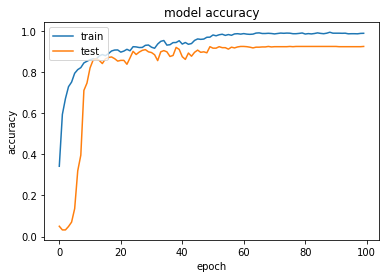

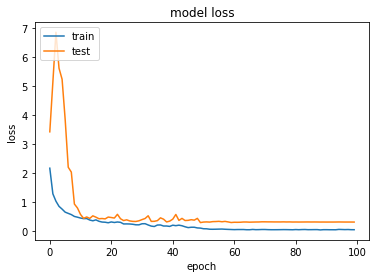

In [17]:
# plot everything
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
model = tf.keras.models.load_model('best_model_Skel2D.h5')
_, train_accuracy = model.evaluate(X_1, Y)
_, test_accuracy = model.evaluate(X_test_1, Y_test)

1960/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 3s 1ms/sample - loss: 0.0063 - acc: 0.9974


840/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [19]:
print('Accuracy on train set: {:.2f}%'.format(100 * train_accuracy))
print('Accuracy on test set: {:.2f}%'.format(100 * test_accuracy))

Accuracy on train set: 99.74%
Accuracy on test set: 92.62%


In [20]:
Y_pred = model.predict(X_test_1)
if (n_classes == 14):
    labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake']
else:
    labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']
y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

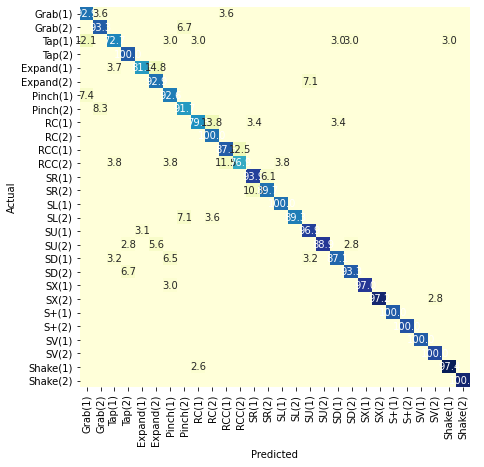

In [21]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_14.png', labels, ymap=None, figsize=(7,7))

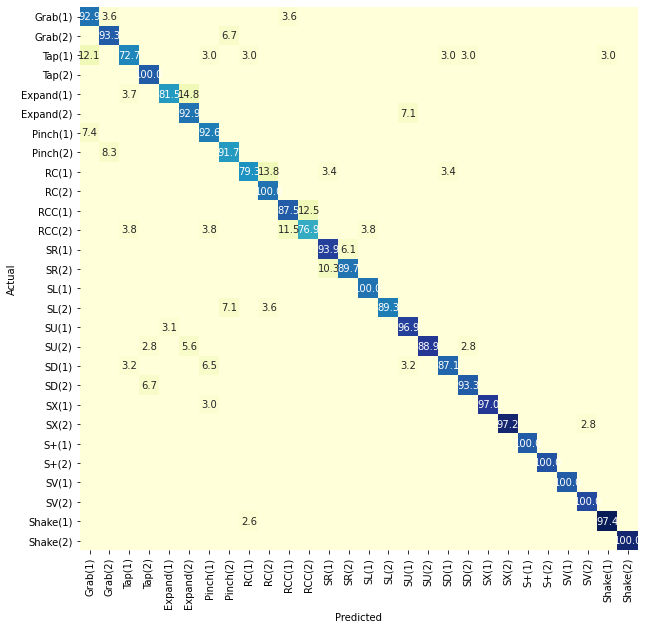

In [22]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_14.png', labels, ymap=None, figsize=(10,10))